Copying over some of the Eps ind stuff and using to develop prepare_iue.py

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d



import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse

from astropy.units import cds
cds.enable()

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/hwo/data/iue/'


In [5]:
mxlos = glob.glob('{}/HIP_108870/*mxlo.gz'.format(path))
swls = []
lwls = []
for spec in mxlos:
    if spec != '/media/david/2tb_ext_hd/hddata/hwo/data/iue/HIP_108870/lwr10686.mxlo.gz':
        if os.path.split(spec)[1][0:2] == 'sw':
            swls.append(spec)
        elif os.path.split(spec)[1][0:2] == 'lw':
            lwls.append(spec)

print(swls)

['/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp01577.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp16837.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp06704.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp13891.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp14035.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp14159.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp14204.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp14259.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp14303.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp15031.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp15076.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp15108.mxlo.gz', '/media/david/2tb_ext_hd/hddata/hwo/data/iue//HIP_108870/swp15134.mxlo.gz', '/media/dav

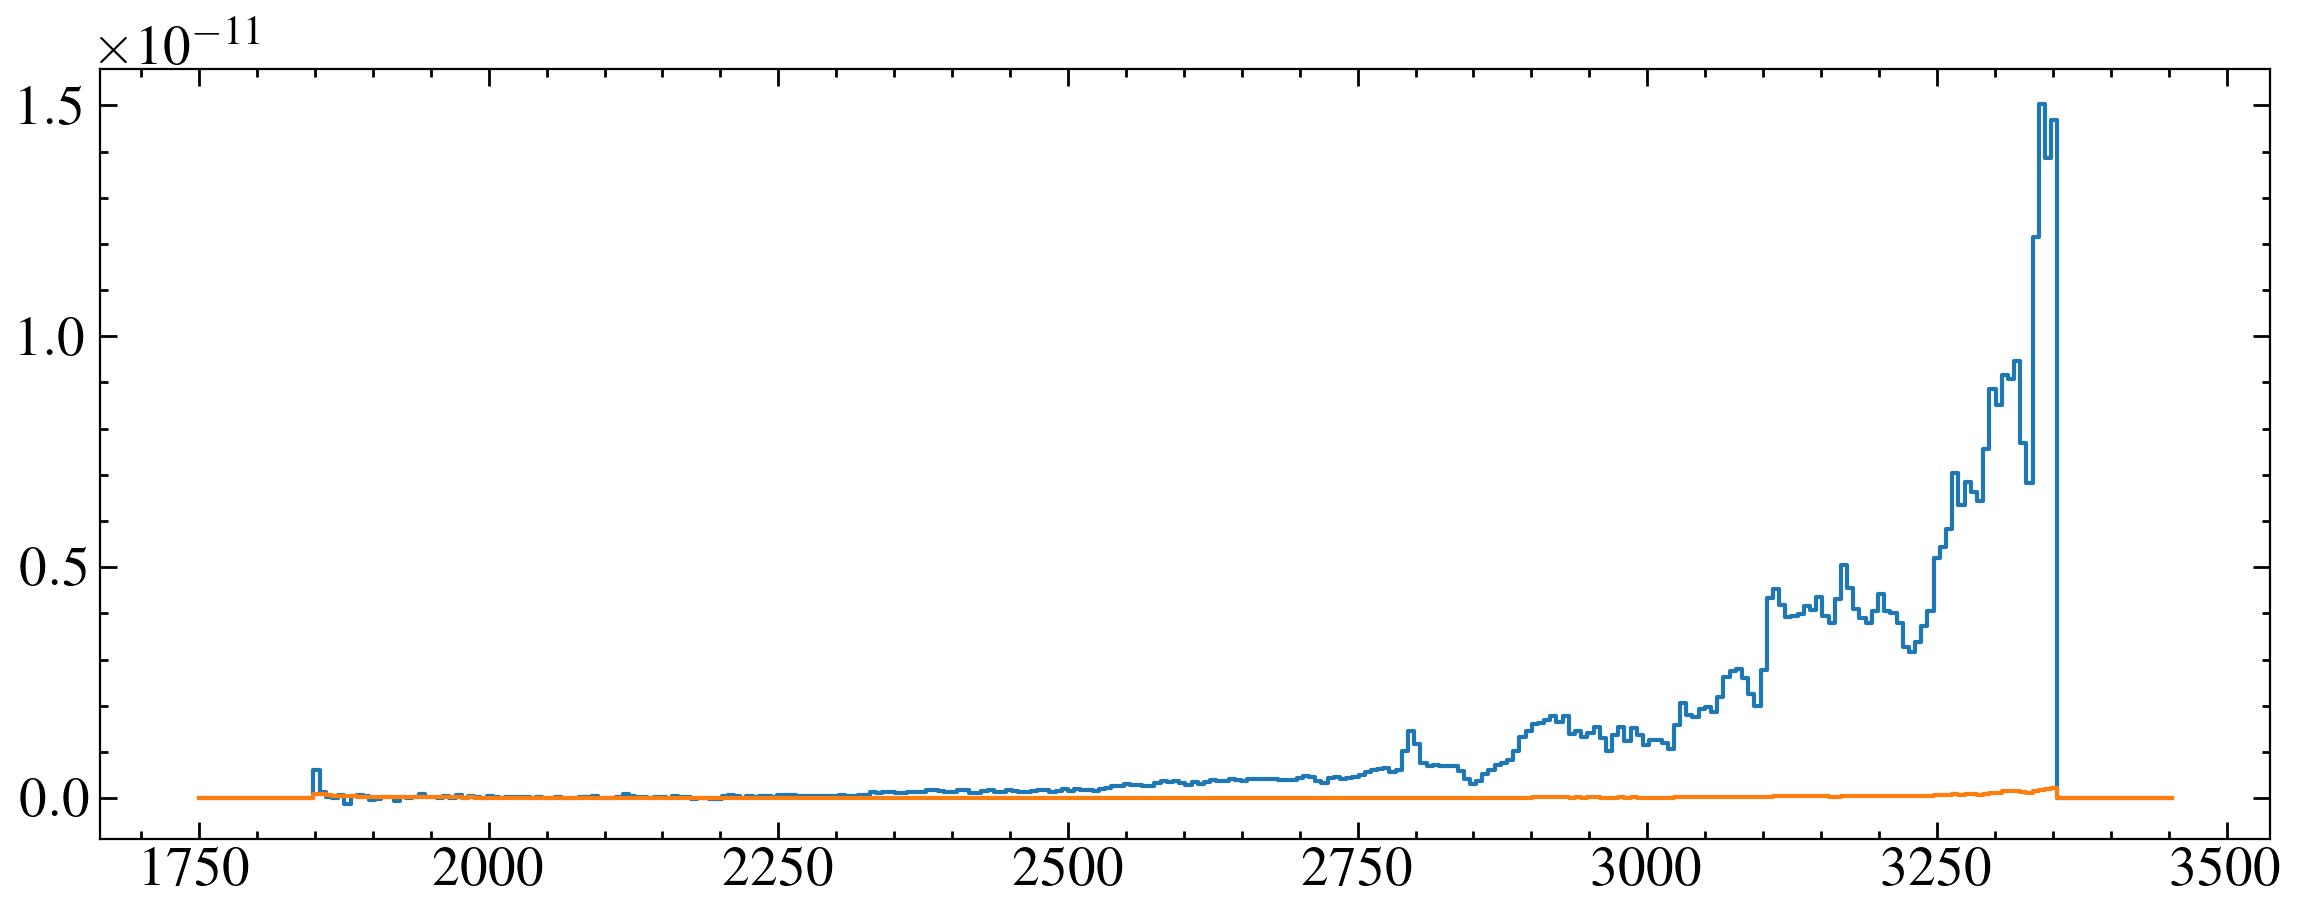

In [8]:
from scipy import stats
from astropy.stats import poisson_conf_interval
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
from astropy.nddata import StdDevUncertainty



def coadd_iue(spectra, dq_cut=0, rebin=True, rebin_pix=2):
    """
    Coadds IUE spectra using throughput weighting and dq masking. Bins by factor two by default
    """
    fluxes = []
    dqs = []
    waves = []
    counts = []
    nets = []
    for spec in spectra:
        hdul = fits.open(spec)
        hdr = hdul[0].header
        data = hdul[1].data
        hdul.close()
        fluxes.append(data[0]['FLUX'])
        dqs.append(-1*data[0]['QUALITY'])
        counts.append(data[0]['NET']+data[0]['BACKGROUND']) 
        nets.append(data[0]['NET'])
        w = np.array([data[0]['WAVELENGTH']+ data[0]['DELTAW']*i for i in range(data[0]['NPOINTS'])])
        waves.append(w)

    #mask and coadd data, weighted by throughput
    mask = np.array(dqs) > dq_cut
    fluxes = np.ma.array(fluxes, mask = mask)
    nets = np.ma.array(nets, mask = mask)
    coadd_flux = np.ma.average(fluxes,weights=nets/fluxes, axis=0).data

    #sum all counts and calculate S/N
    sumcounts = np.ma.sum(np.ma.array(counts, mask=mask), axis=0)#.data 
    sumnets = np.ma.sum(np.ma.array(nets, mask=mask), axis=0)#.data 
    coadd_error = (sumcounts**0.5 / sumnets) * coadd_flux #/ np.sum(exptimes)
    n = 0
    while np.min(coadd_error) < 0.0 and n < 100: #removing negative error values and replacing them with adjacent points. N count stops infinate loop
        new_error = np.copy(coadd_error)
        for i in range(len(new_error)):
            if new_error[i] < 0.0:
                new_error[i] = np.mean((new_error[i-1], new_error[i-1]))
        coadd_error = new_error
        n +=1
                                    
    # test without the dq masking
    # coadd_flux = np.average(fluxes, weights=1/np.array(throughputs), axis=0)
    # sumcounts = np.sum(np.array(counts), axis=0)
    # coadd_error = np.sqrt(sumcounts) / sumcounts * coadd_flux #/ np.sum(exptimes)


    wavelength = stats.mode(waves).mode # wavelength arrays are near identical so just use the mode in each case. Experiment with uniform grid?

    # rebinning 
    if rebin:
        w0, w1 = wavelength[0], wavelength[-1]
        dw = np.median(np.diff(wavelength)) *rebin_pix
        new_wavelength = np.arange(w0, w1, dw)
        fluxcon = FluxConservingResampler(extrapolation_treatment='zero_fill')
        input_spec = Spectrum1D(spectral_axis=wavelength*u.AA, 
                                flux=coadd_flux*u.erg/u.s/u.cm**2/u.AA ,
                                uncertainty= StdDevUncertainty(coadd_error))
        new_spec_fluxcon = fluxcon(input_spec, new_wavelength*u.AA)
        wavelength = (new_spec_fluxcon.spectral_axis.value)
        coadd_flux = (new_spec_fluxcon.flux.value)
        coadd_error = (1/(new_spec_fluxcon.uncertainty.array**0.5))
       
        
    
    
    return wavelength, coadd_flux, coadd_error
    
fig, ax = plt.subplots()

w2, f2, e2 = coadd_iue(lwls)

# fig, ax = plt.subplots()

ax.step(w2, f2, where='mid')
ax.step(w2, e2, where='mid')

# print(np.median(f2/e2))
# ax.step(w2, f2/e2)

# f2i = convolve(f2, Box1DKernel(3))
# ax.step(w2, f2i, where='mid')
# ax.step(w2, e2, where='mid')

# ax.step(w2, f2i/e2,  where='mid')

# for spec in swls:
#     data = fits.getdata(spec, 1)
#     w2 = np.array([data[0]['WAVELENGTH']+ data[0]['DELTAW']*i for i in range(data[0]['NPOINTS'])])
    # print(w2[-1])
    # plt.plot(np.arange(data[0]['NPOINTS']), w2, alpha=0.5)
    
    # print(data['WAVELENGTH'], data['DELTAW'], data['NPOINTS'])
        # mxlos

#darn will have to interpolate onto a common grid. Differences are so small, better to ignore them.


#if os.path.split(spec)[1][0:2] == 'sw':
# ax.step(w_sw, f_sw, where='mid')
# ax.step(w_sw, e_sw, where='mid')
# ax.step(w_lw, f_lw, where='mid', c= plt.cm.plasma(cols[2]))
# ax.step(w_sw, f_sw/e_sw)
# ax.set_ylim(-1, 10)
# ax.set_yscale('log')


In [11]:
newdict = dict(test=[], testagain=[1,2])

for key in newdict.keys():
    print(key)
    if len(newdict[key]) > 0:
        print('yes')

test
testagain
yes


In [12]:
hdr = fits.getheader(mxlos[0])

In [19]:
start = hdr['LJD-OBS']*cds.JD
print(start)

2447618.23089 JD


In [17]:
start.to(cds.MJD)

<Quantity 2447618.23089 MJD>